# Text classification

It's common task for machine learning and in this notebook is showen how it can be solved with deep learning, in particular pytorch.

In [1]:
import numpy as np
import pandas as pd

import re
import string
from collections import Counter

from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import (
    DataLoader, random_split, Dataset
)
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

import gensim.downloader as api

import matplotlib.pyplot as plt
from IPython.display import clear_output

## Data

Here we deal with pretty simple dataset. That just contains review on movies and markers that show weather this comment is positive or negative. We will build a model that can "read" the content and evaluate whether a given comment is positive or negative.

In [2]:
data = pd.read_csv("texts_classification_files/IMDB Dataset.csv")
#data = pd.read_csv("../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
data.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Text vectorisation

We need to vectorise our text. There is method that allows to each word match some vector. Here we are using ready tool for this purpose.

In [3]:
fasttext = api.load('glove-twitter-25')

Here is example how this tool can be used for some words.

In [4]:
print("man ->", fasttext["man"])
print("king ->", fasttext["king"])

man -> [ 0.37013  -0.39648  -0.021712 -0.6301   -0.3189    0.34329   0.10968
  0.4879   -0.48663   0.36837  -0.39179   0.25414  -4.9282    0.067597
  0.37147   0.36817   1.1655    0.092116 -0.87735  -0.74562   0.40903
  1.5672   -0.23879   0.24755   0.76386 ]
king -> [-0.74501  -0.11992   0.37329   0.36847  -0.4472   -0.2288    0.70118
  0.82872   0.39486  -0.58347   0.41488   0.37074  -3.6906   -0.20101
  0.11472  -0.34661   0.36208   0.095679 -0.01765   0.68498  -0.049013
  0.54049  -0.21005  -0.65397   0.64556 ]


## Vocabulary

Vocabulary is object that describes all worlds that we allowed to use in our model and basic operation under them.

The following cell represents possible realisation of the vocabulary in python:

In [5]:
class Vocabulary:
    def __init__(self, texts: list[str], min_freq: int = 10):
        text = ' '.join(texts)

        text = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ", text)
        text = re.sub("[^a-zA-Z]", " ", text)

        while '  ' in text:
            text = text.replace('  ', ' ')

        words = text.strip().lower().split()

        c = Counter(words)

        self.vocabulary = list(set([word for word in words if c[word] >= min_freq]))
        self.vocabulary.append('<unk>')
        self._idx2word = {i: word for i, word in enumerate(self.vocabulary)}
        self._word2idx = {word: i for i, word in enumerate(self.vocabulary)}

    def get_vocabulary(self):
        return self.vocabulary

    def idx2word(self, idx: int):
        if idx not in self._idx2word:
            return '<unk>'

        return self._idx2word[idx]

    def word2idx(self, word: str):
        word = word.lower()
        if word not in self._word2idx:
            return self._word2idx['<unk>']

        return self._word2idx[word]
    
    def encode(self, text):
        result = []

        for word in text.split():
            result.append(self.word2idx(word))

        return result

    def build_vectors(self, fasttext):
        vectors = []
        
        for word in self.vocabulary:
            if fasttext.has_index_for(word):
                vectors.append(fasttext[word])
            else:
                vectors.append(np.zeros(25))

        return np.stack(vectors)

The vocabulary must be common to both the training and test datasets, so in the following cell the vocabulary has been created under words that can be found in the given sample.

In [6]:
data["sentiment"] = data["sentiment"].replace({"positive" : 1, "negative" : 0})
vocab = Vocabulary(data["review"].values)

## Datasets/dataloaders

The following cell extends `torch.dataset` to work with data from the example under consideration and creates ti's instances for training and test samples.

In [7]:
class IMDB(Dataset):
    def __init__(self, texts, labels, vocab):
        
        self.texts = texts
        self.labels = labels
        self.vocab = vocab

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        text = torch.LongTensor(self.vocab.encode(text))
        label = torch.FloatTensor([label])

        return text, label

    def __len__(self):
        return len(self.texts)


train_dataset, test_dataset = np.split(data, [45000], axis = 0)
train_dataset = IMDB(
    train_dataset["review"].values, 
    train_dataset["sentiment"].values, 
    vocab
)
test_dataset = IMDB(
    test_dataset["review"].values, 
    test_dataset["sentiment"].values, 
    vocab
)

Same for dataloaders.

In [8]:
pad_idx = len(vocab.vocabulary)
def collate_fn(batch):
    texts = pad_sequence(
        [b[0] for b in batch], 
        padding_value=pad_idx, 
        batch_first=True
    )
    labels = torch.stack([b[1] for b in batch])
    
    return texts, labels


train_loader = DataLoader(
    train_dataset, 
    batch_size=64, 
    collate_fn=collate_fn, 
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=64, 
    collate_fn=collate_fn, 
    pin_memory=True
)

## Model architecture

In [9]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, pad_idx):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        self.convs = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Conv2d(
                        in_channels = 1, 
                        out_channels = 16, 
                        kernel_size = (fs, embedding_dim)
                    ),
                    nn.Dropout(0.5)
                )
                for fs in [2, 3, 4, 5]
            ]
        )
        
        self.fc = nn.Linear(4 * 16, 1)
    
    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)

        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]
        x = [F.max_pool1d(_, _.shape[2]).squeeze(2) for _ in x]

        return self.fc(torch.cat(x, dim = 1))

## Model fitting functions

The following cells define a function that implements model optimisation, evaluation and visualisation procedures.

In [10]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc.item()


def train(model) -> tuple[float, float]:
    model.train()

    train_loss = 0
    train_accuracy = 0

    for x, y in tqdm(train_loader, desc='Train'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()
        train_accuracy += binary_accuracy(output, y)

        loss.backward()

        optimizer.step()

    train_loss /= len(train_loader)
    train_accuracy /= len(train_loader)

    return train_loss, train_accuracy

@torch.inference_mode()
def evaluate(model, loader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total_accuracy = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()
        total_accuracy += binary_accuracy(output, y)

    total_loss /= len(loader)
    total_accuracy /= len(loader)

    return total_loss, total_accuracy

def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

## Fitting

This is where everything necessary for running the optimisation algorithm is defined.

In [28]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

model = TextCNN(
    vocab_size=len(vocab.vocabulary) + 1, 
    embedding_dim=25,
    pad_idx=pad_idx
).to(device)
vectors = vocab.build_vectors(fasttext)
model.embedding.weight.data[:len(vectors)] = torch.from_numpy(vectors)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=1e-3)

cpu


The fitting process can be started with the next cell. It can take a considerable amount of time, so the results are saved in temporary files.

```python
history = {
    "train_loss" : [],
    "valid_loss" : [],
    "train_accuracy" : [],
    "valid_accuracy" : []
}
```

```python
for epoch in range(5):
    train_loss, train_accuracy = train(model)
    valid_loss, valid_accuracy = evaluate(model, test_loader)

    history["train_loss"].append(train_loss)
    history["valid_loss"].append(valid_loss)
    history["train_accuracy"].append(train_accuracy)
    history["valid_accuracy"].append(valid_accuracy)

    clear_output()

    plot_stats(
        history["train_loss"], history["valid_loss"],
        history["train_accuracy"], history["valid_accuracy"],
        "Learning curves"
    )
```

```python
with open("texts_classification_files/model.pck", "wb") as f:
    torch.save(model.state_dict(), f)
with open("texts_classification_files/history.pck", "wb") as f:
    pickle.dump(history, f)
```

The following cell shows the learning curves of the model fitting process.

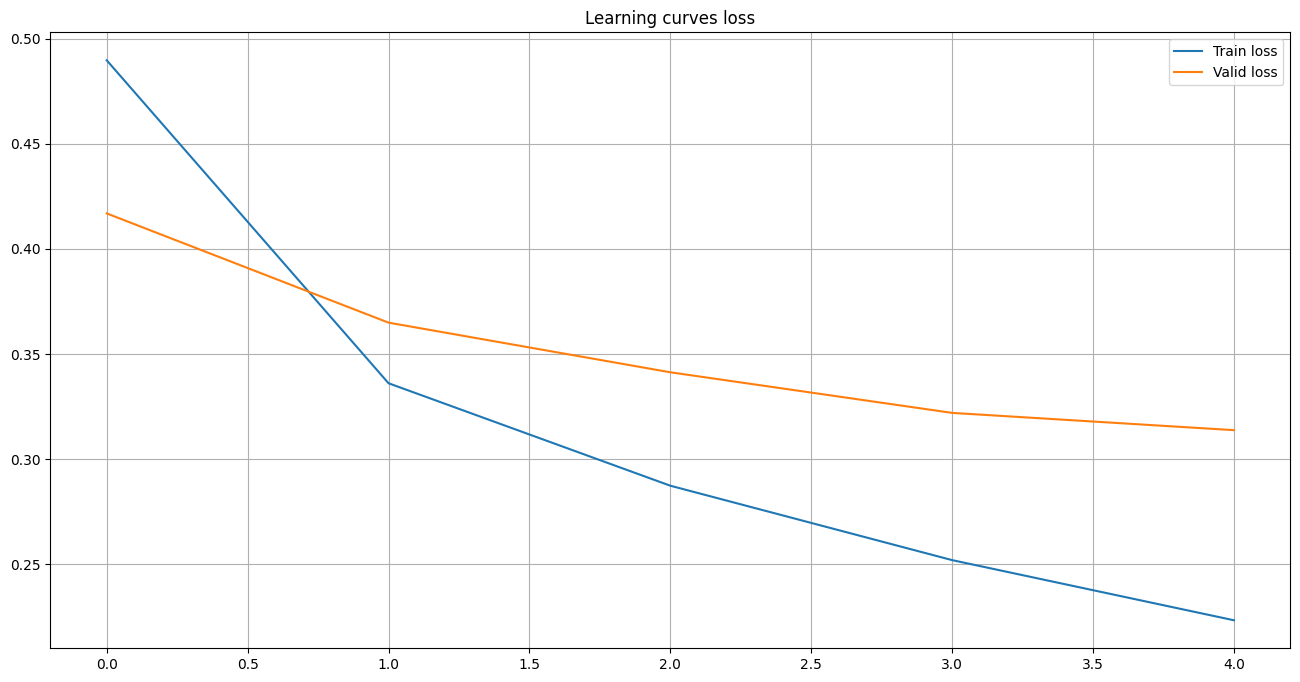

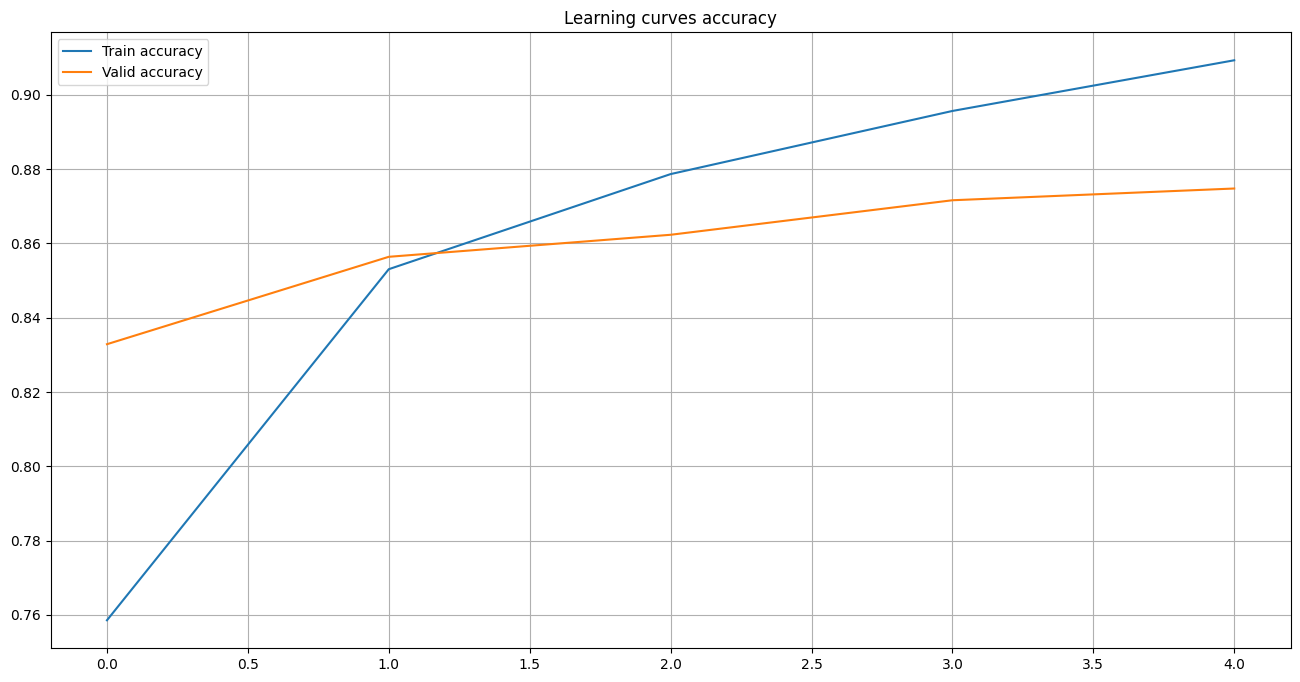

In [79]:
with open("texts_classification_files/history.pck", "rb") as f:
    history = pickle.load(f)

plot_stats(
    history["train_loss"], history["valid_loss"],
    history["train_accuracy"], history["valid_accuracy"],
    "Learning curves"
)